# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек и данных

Импортируем необходимые библиотеки и первично ознакомимся с данными.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor, Pool, cv

In [2]:
pd.set_option('display.precision', 2)

In [3]:
data = pd.read_csv('/datasets/autos.csv')

Подготовим функцию для ознакомления с датасетом

In [4]:
def info_data(df):
    print(df.info())
    print()
    print((df.isna().sum() / df.shape[0]) * 100)
    print()
    display(df.head(10))

Ознакомимся с датасетом

In [5]:
info_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


В датасете имебтся пропусти в категориальных данных. Так же имеются столбцы с датами, опознанные как строки, исправим этот момент.

In [6]:
columns = ['DateCrawled', 'DateCreated', 'LastSeen']
list_year = list()
list_month = list()
list_day = list()
for col in columns:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')
    year = 'y_' + col
    month = 'm_' + col
    day = 'd_' + col
    data[year] = pd.DatetimeIndex(data[col]).year
    data[month] = pd.DatetimeIndex(data[col]).month
    data[day] = pd.DatetimeIndex(data[col]).day
    list_year.append(year)
    list_month.append(month)
    list_day.append(day)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,y_DateCrawled,m_DateCrawled,d_DateCrawled,y_DateCreated,m_DateCreated,d_DateCreated,y_LastSeen,m_LastSeen,d_LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,2016,3,24,2016,3,24,2016,4,7
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,2016-04-07 01:46:50,2016,3,24,2016,3,24,2016,4,7
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,2016,3,14,2016,3,14,2016,4,5
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,2016,3,17,2016,3,17,2016,3,17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,2016,3,31,2016,3,31,2016,4,6


Заполним пропуски в данных. Ввиду того, что пропуски только в категориальных данных, будем заполнять `unknow`.

In [7]:
columns_nan = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for col in columns_nan:
    data[col] = data[col].fillna('unknow')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,y_DateCrawled,m_DateCrawled,d_DateCrawled,y_DateCreated,m_DateCreated,d_DateCreated,y_LastSeen,m_LastSeen,d_LastSeen
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,2016,3,24,2016,3,24,2016,4,7
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,2016-04-07 01:46:50,2016,3,24,2016,3,24,2016,4,7
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,2016,3,14,2016,3,14,2016,4,5
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,2016,3,17,2016,3,17,2016,3,17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,2016,3,31,2016,3,31,2016,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknow,2005,manual,0,colt,150000,7,petrol,...,2016-03-21 10:42:49,2016,3,21,2016,3,21,2016,3,21
354365,2016-03-14 17:48:27,2200,unknow,2005,unknow,0,unknow,20000,1,unknow,...,2016-04-06 00:46:52,2016,3,14,2016,3,14,2016,4,6
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,...,2016-03-11 18:17:12,2016,3,5,2016,3,5,2016,3,11
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,...,2016-04-07 07:15:26,2016,3,19,2016,3,19,2016,4,7


### Анализ данных

Перед обучением моделей, убедимся, что все данные, которые есть в датасете валидны, а так же, что в том, что в данных нет выбросов, которые могут повлиять на качество модели.

Для начала посмотрим, как распределены данных по датам.

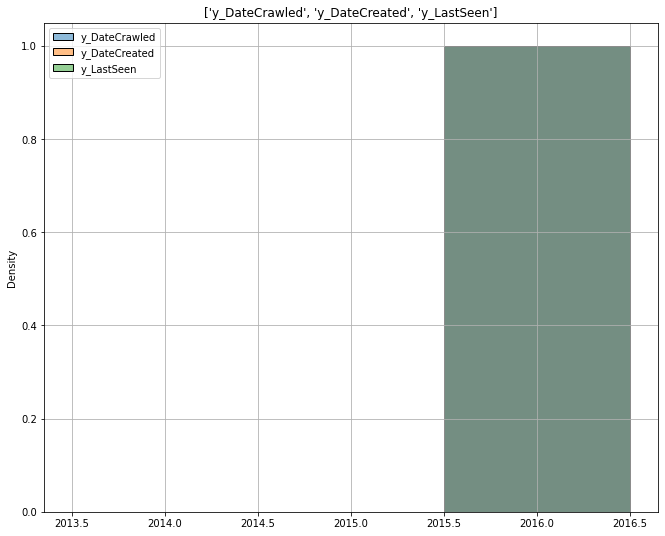

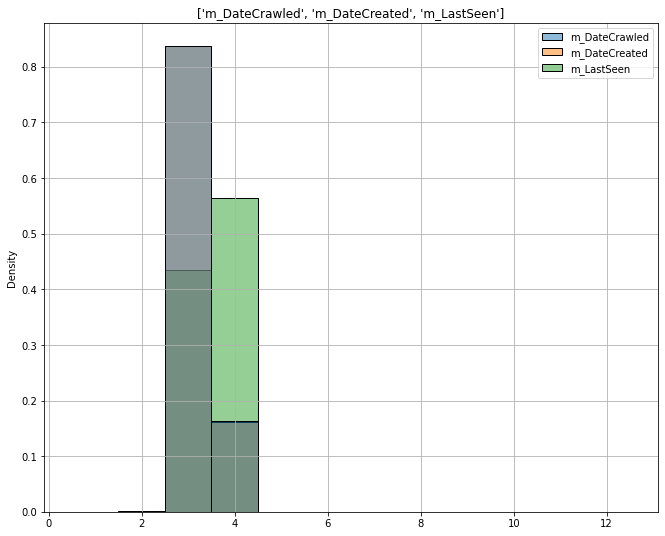

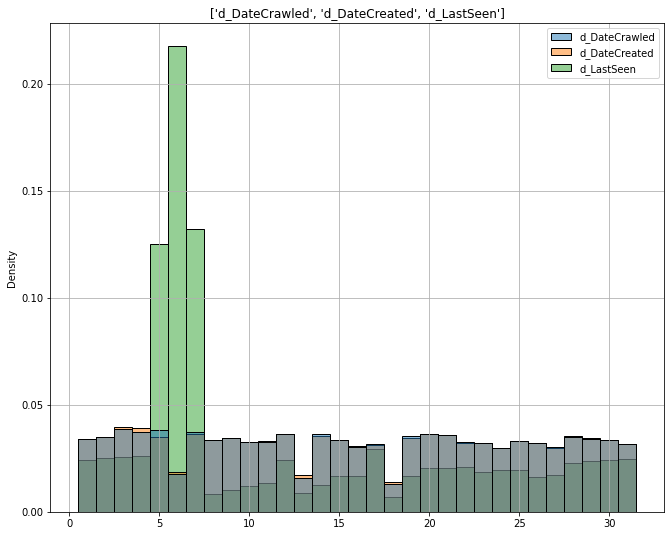

In [8]:
list_columns_date = [list_year, list_month, list_day]
for col in list_columns_date:
    fig, ax1 = plt.subplots(figsize=(11,9))
    plt.title(str(col))
    plt.grid()
    sns.histplot(data[col], discrete=True, stat="density", common_norm=False, alpha=0.5, ax=ax1)
    

Отметим, что все данные от 2016 года. В нашем случае, когда проверка моделей будет осуществляться на части имеющихся данных, столбцы с годами можно удалить, дабы уменьшить загрузку машины.

Так же, можно отметить выброс в активности пользователей в разбивке по дням.

Ознакомимся с числовыми данными.

In [9]:
list_numeric_col = ['RegistrationYear', 'RegistrationMonth', 'Price', 'Kilometer', 'NumberOfPictures', 'Power']
list_numeric_lim = [(1900,2020), (0,12), (0,20000), (0, 200000), (0,5), (0, 3000)]
for col in list_numeric_col:
    print(col)
    print()
    print(data[col].describe())
    print()

RegistrationYear

count    354369.00
mean       2004.23
std          90.23
min        1000.00
25%        1999.00
50%        2003.00
75%        2008.00
max        9999.00
Name: RegistrationYear, dtype: float64

RegistrationMonth

count    354369.00
mean          5.71
std           3.73
min           0.00
25%           3.00
50%           6.00
75%           9.00
max          12.00
Name: RegistrationMonth, dtype: float64

Price

count    354369.00
mean       4416.66
std        4514.16
min           0.00
25%        1050.00
50%        2700.00
75%        6400.00
max       20000.00
Name: Price, dtype: float64

Kilometer

count    354369.00
mean     128211.17
std       37905.34
min        5000.00
25%      125000.00
50%      150000.00
75%      150000.00
max      150000.00
Name: Kilometer, dtype: float64

NumberOfPictures

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: f

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

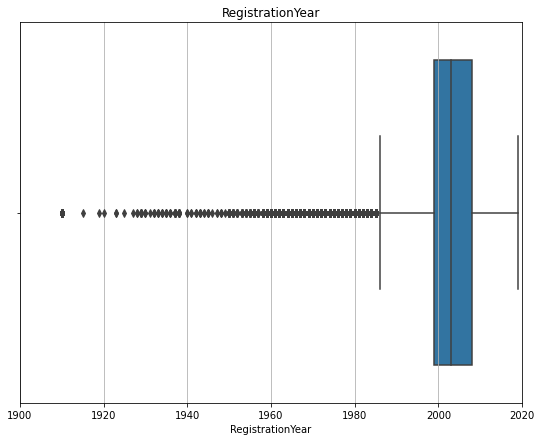

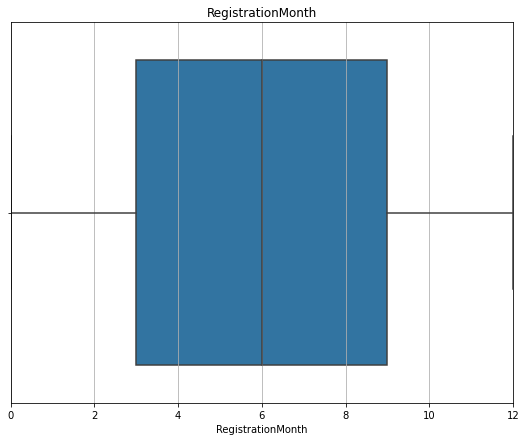

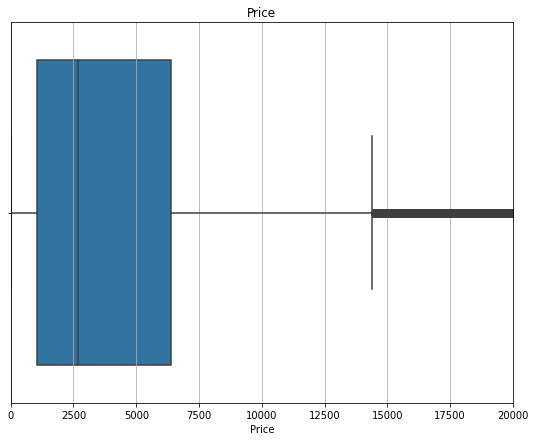

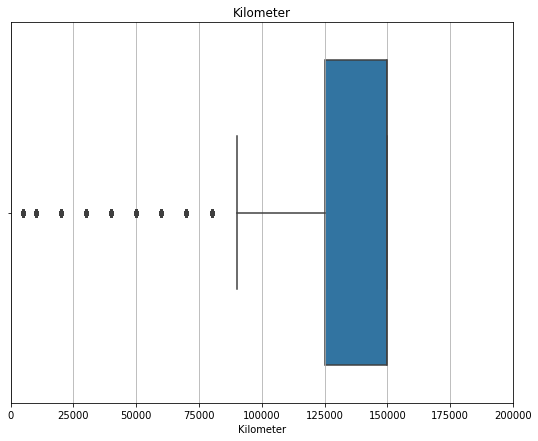

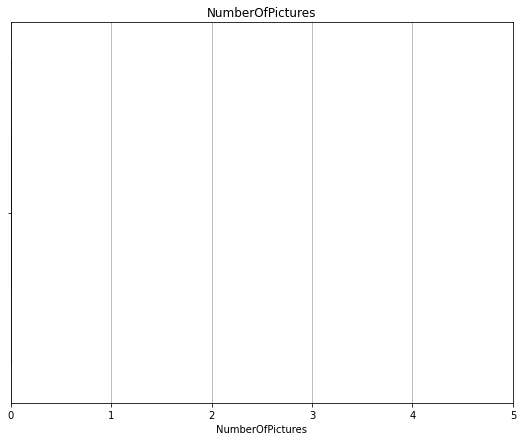

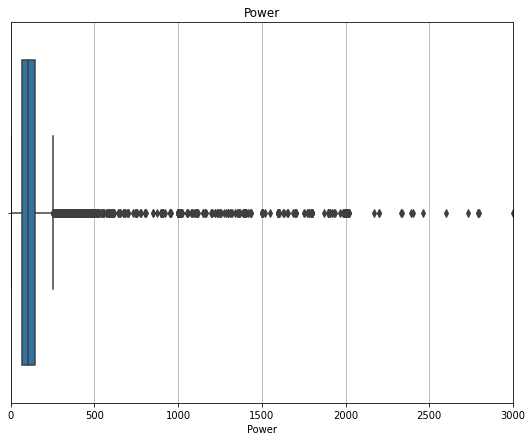

In [10]:
for col, lim in zip(list_numeric_col, list_numeric_lim):
    fig, ax1 = plt.subplots(figsize=(9,7))
    plt.title(str(col))
    plt.grid()
    plt.xlim(lim)
    sns.boxplot(data[col], ax=ax1)

Беглое ознакомление показало, что есть выбросы и просто не валидные строки, например `RegistrationMonth` = 0.
Так же обращают на себя внимание следующие выбросы:

- `Power` = 0 и `Power` > 270;
- `Price` = 0;
- 1985 > `RegistrationYear` > 2016;

Все эти выбросы могут ухудшить качество модели. Следует исследовать их влияние.

На основе числового исследование данных, ознакомимся с данными и графически.

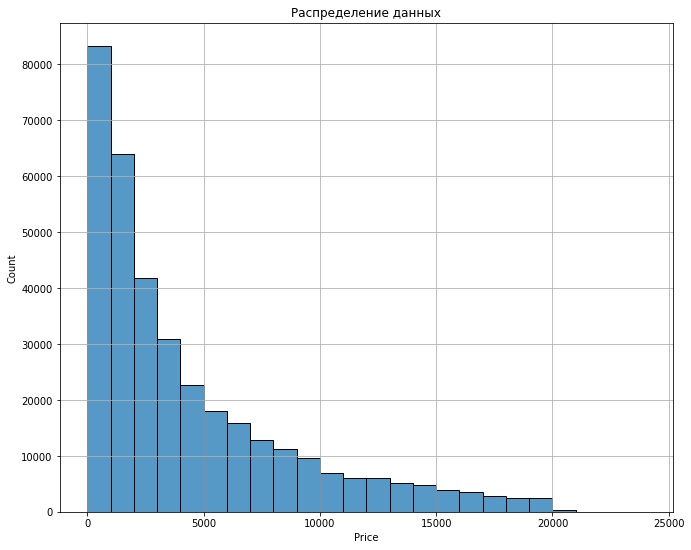

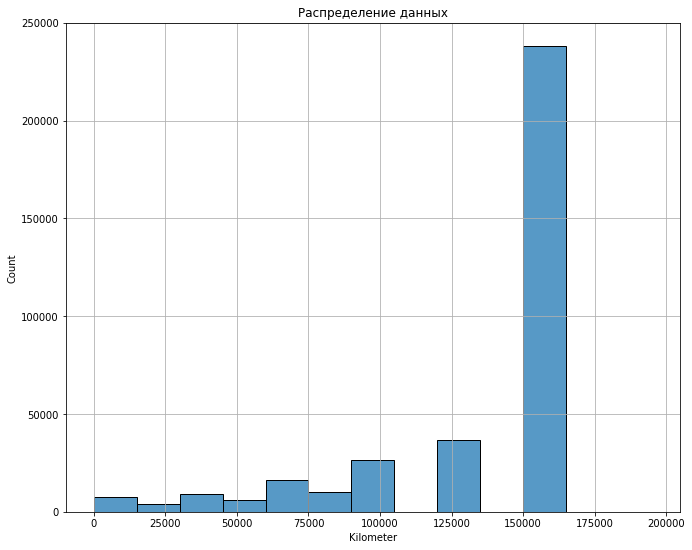

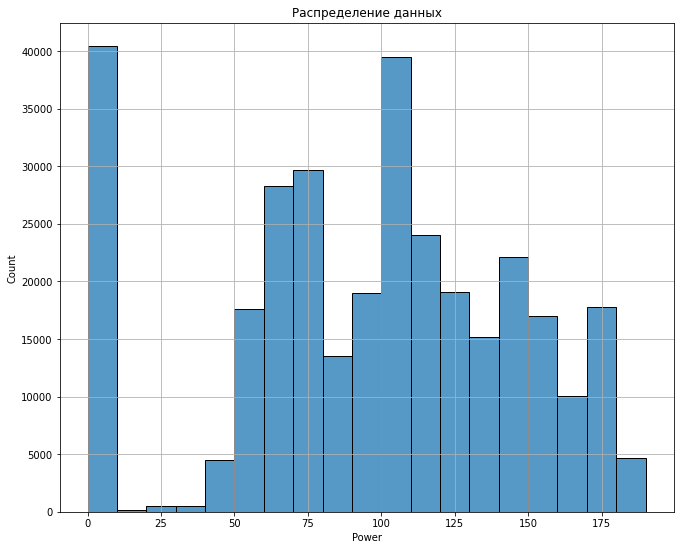

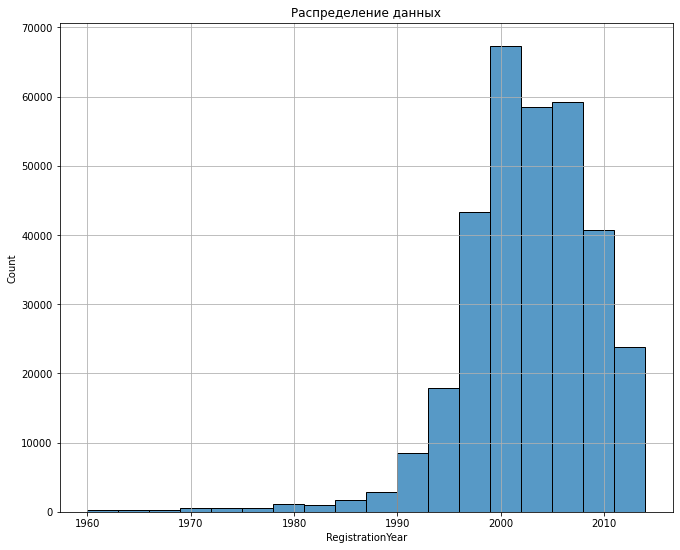

In [11]:
list_numeric_col = ['Price', 'Kilometer', 'Power', 'RegistrationYear']
bins_list = [
    [i for i in range(0,25000, 1000)],
    [i for i in range(0,200000, 15000)],
    [i for i in range(0, 200, 10)],
    [i for i in range(1960, 2017,3)]]
for col, bb in zip(list_numeric_col, bins_list):
    fig, ax1 = plt.subplots(figsize=(11,9))
    plt.title('Распределение данных')
    plt.grid()
    sns.histplot(data[col], ax=ax1, bins=bb)

В целом, все данные в порядке и распределены нормально (некоторые со смещением). Однако, имеется большой выброс `Power` = 0.

Теперь посмотрим на категориальные данные.

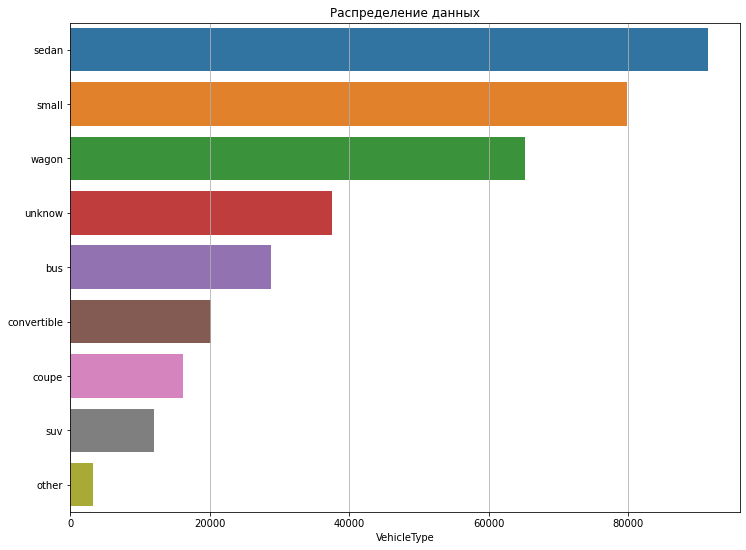

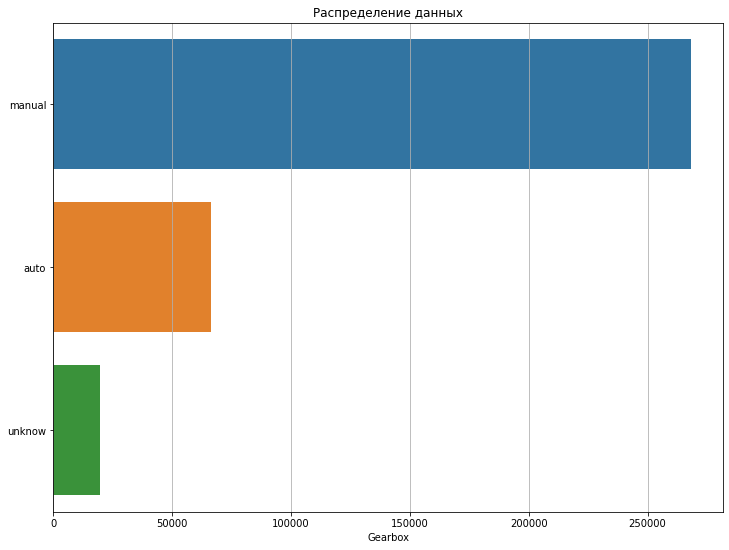

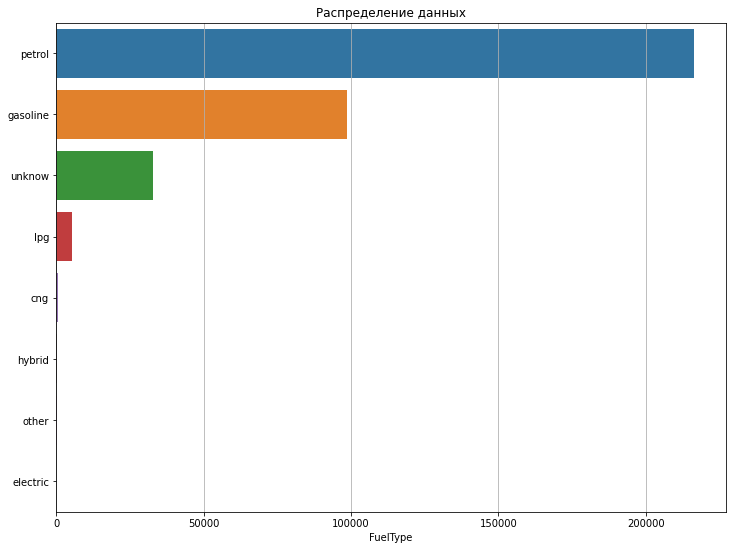

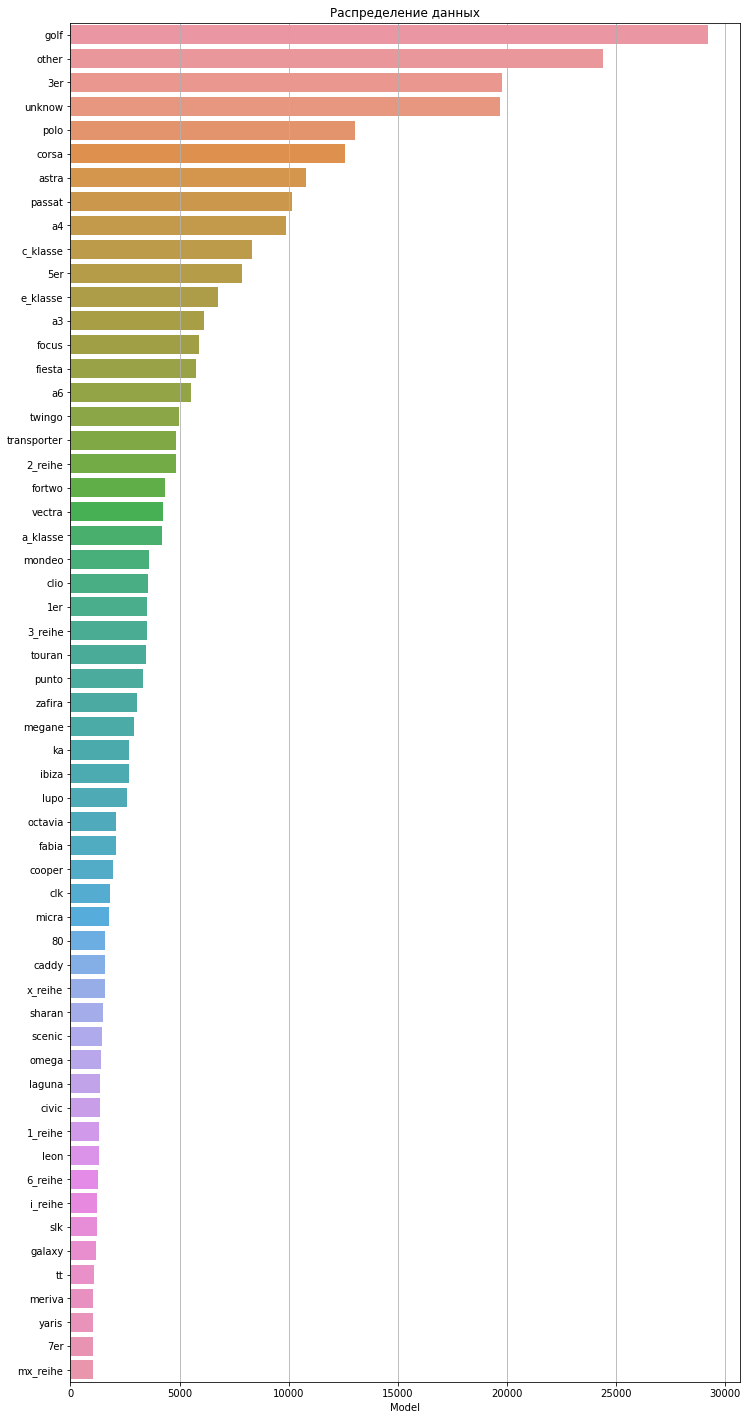

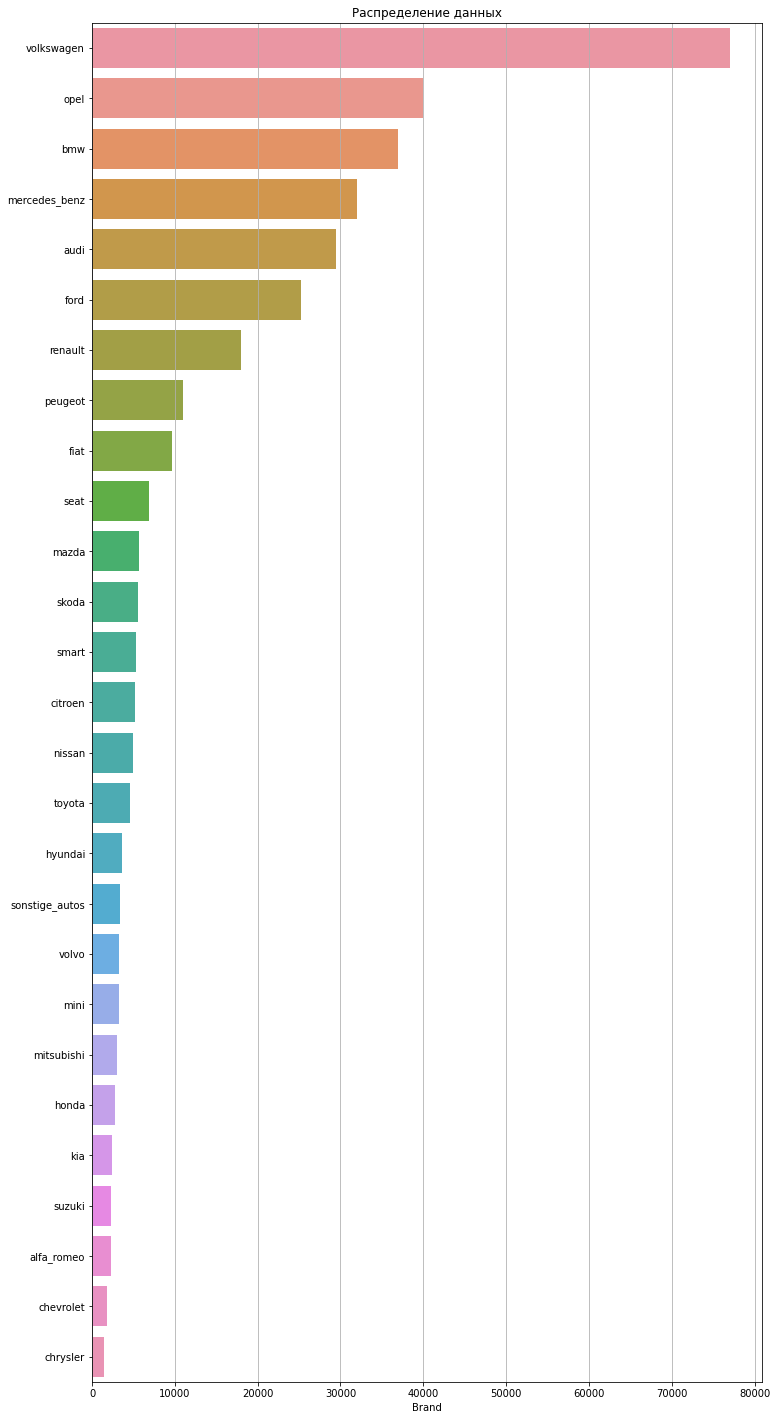

In [12]:
list_cat1 = ['VehicleType', 'Gearbox', 'FuelType']
for col in list_cat1:
    fig, ax1 = plt.subplots(figsize = (12,9))
    plt.grid()
    plt.title('Распределение данных')
    sns.barplot(data=data,
                y=list(data[col].value_counts().index),
                x=data[col].value_counts(), ax=ax1)

list_cat2 = ['Model', 'Brand']
for col in list_cat2:
    fig, ax1 = plt.subplots(figsize = (12,25))
    plt.grid()
    plt.title('Распределение данных')
    sns.barplot(data=data,
                y=list(data[col].value_counts()[data[col].value_counts() > 1000].index),
                x=data[col].value_counts()[data[col].value_counts() > 1000], ax=ax1)

Здесь замечаний нет.

Посмотрим, сколько строк с данными, которые мы определили как выброс, имеется в датасете.

In [13]:
display(data.query(
'Power == 0 or RegistrationMonth == 0 or Price == 0 or RegistrationYear < 1985 or RegistrationYear > 2016 or Power > 270'))
print('Доля строк с выбросами:', 
      data.query(
'Power == 0 or RegistrationMonth == 0 or Price == 0 or RegistrationYear < 1985 or RegistrationYear > 2016 or Power > 270').shape[0] / data.shape[0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,y_DateCrawled,m_DateCrawled,d_DateCrawled,y_DateCreated,m_DateCreated,d_DateCreated,y_LastSeen,m_LastSeen,d_LastSeen
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,2016,3,24,2016,3,24,2016,4,7
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,...,2016-03-25 16:47:58,2016,3,21,2016,3,21,2016,3,25
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknow,...,2016-03-31 17:17:06,2016,3,17,2016,3,17,2016,3,31
15,2016-03-11 21:39:15,450,small,1910,unknow,0,ka,5000,0,petrol,...,2016-03-19 08:46:47,2016,3,11,2016,3,11,2016,3,19
16,2016-04-01 12:46:46,300,unknow,2016,unknow,60,polo,150000,0,petrol,...,2016-04-01 12:46:46,2016,4,1,2016,4,1,2016,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,unknow,1995,unknow,0,unknow,125000,3,petrol,...,2016-04-06 14:18:04,2016,3,31,2016,3,31,2016,4,6
354346,2016-03-07 17:06:35,2600,unknow,2005,auto,0,c_klasse,150000,9,unknow,...,2016-03-08 21:28:38,2016,3,7,2016,3,7,2016,3,8
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,...,2016-03-29 10:17:23,2016,3,27,2016,3,27,2016,3,29
354364,2016-03-21 09:50:58,0,unknow,2005,manual,0,colt,150000,7,petrol,...,2016-03-21 10:42:49,2016,3,21,2016,3,21,2016,3,21


Доля строк с выбросами: 0.2377098448227695


Почти 20%. Уменьшение исходной выборки на такую долю не желательно, но выбросы могут сильно влиять на результат. Поэтому на следубщем этапе посмотрим, насколько сильно различается качество моделей при обучение на выборке с выбросами и без них.

Удалим столбцы, данные в которых не влияют на цену.

In [14]:
data = data.drop([*columns, 'y_DateCrawled', 'y_DateCreated', 'y_LastSeen',
                  'm_LastSeen', 'd_LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,m_DateCrawled,d_DateCrawled,m_DateCreated,d_DateCreated
0,480,unknow,1993,manual,0,golf,150000,0,petrol,volkswagen,unknow,3,24,3,24
1,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,3,24,3,24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,3,14,3,14
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,17,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,31,3,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,unknow,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,3,21,3,21
354365,2200,unknow,2005,unknow,0,unknow,20000,1,unknow,sonstige_autos,unknow,3,14,3,14
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,3,5,3,5
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,3,19,3,19


Из исходного датасета удалим строки с выбросами.

In [15]:
data = data.query('Power != 0 and RegistrationMonth != 0 and Price != 0 and RegistrationYear > 1985 and RegistrationYear <= 2016 and Power < 270')
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,m_DateCrawled,d_DateCrawled,m_DateCreated,d_DateCreated
1,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,3,24,3,24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,3,14,3,14
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,17,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,31,3,31
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknow,2016,auto,150,159,150000,12,unknow,alfa_romeo,no,3,9,3,9
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,3,19,3,19
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,3,5,3,5
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,3,19,3,19


Скопируем исходный датасет и для него же, обработаем категориальные признаки.

In [16]:
data_1 = data.copy(deep=True)

In [17]:
f_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']
encoder = OrdinalEncoder()
data = data.reset_index(drop=True)
data[f_cat] = pd.DataFrame(encoder.fit_transform(data[f_cat]), columns=f_cat)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,m_DateCrawled,d_DateCrawled,m_DateCreated,d_DateCreated
0,18300,2.0,2011,1.0,190,224.0,125000,5,2.0,1.0,2.0,3,24,3,24
1,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0,3,14,3,14
2,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0,3,17,3,17
3,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,3,31,3,31
4,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,2.0,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269698,5250,7.0,2016,0.0,150,4.0,150000,12,7.0,0.0,0.0,3,9,3,9
269699,3200,4.0,2004,1.0,225,140.0,150000,5,6.0,30.0,2.0,3,19,3,19
269700,1199,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,0.0,3,5,3,5
269701,9200,0.0,1996,1.0,102,220.0,150000,3,2.0,38.0,0.0,3,19,3,19


Оптимизируем использование памяти. Приведем данные в ряде стобцов к типу `int16`.

In [18]:
col = list(data.columns)
col.remove('Price')
col.remove('Kilometer')
data[col] = data[col].astype('int16')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269703 entries, 0 to 269702
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Price              269703 non-null  int64
 1   VehicleType        269703 non-null  int16
 2   RegistrationYear   269703 non-null  int16
 3   Gearbox            269703 non-null  int16
 4   Power              269703 non-null  int16
 5   Model              269703 non-null  int16
 6   Kilometer          269703 non-null  int64
 7   RegistrationMonth  269703 non-null  int16
 8   FuelType           269703 non-null  int16
 9   Brand              269703 non-null  int16
 10  NotRepaired        269703 non-null  int16
 11  m_DateCrawled      269703 non-null  int16
 12  d_DateCrawled      269703 non-null  int16
 13  m_DateCreated      269703 non-null  int16
 14  d_DateCreated      269703 non-null  int16
dtypes: int16(13), int64(2)
memory usage: 10.8 MB


Разделим получившиеся датасеты на учебные, валидационные и тестовые.

In [20]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)
data_params = data_train.copy(deep=True)
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=123)

data_1_train, data_1_test = train_test_split(data_1, test_size=0.2, random_state=123)
data_1_params = data_1_train.copy(deep=True)
data_1_train, data_1_valid = train_test_split(data_1_train, test_size=0.25, random_state=123)

### Вывод

В данном разделе были импортированы необходимые библиотеки и исходные данные. Проведён анализ данные и их предобработка. Подготовлены 4 датасета: 2 тренировочных (с выбросами и без них) и два тестовых.

## Обучение моделей

В этом разделе определим наилучшие гиперпараметры для моделей.

Для этого, подготовим функцию.

In [21]:
def score1(predict, target):
    # принимает массив предсказаний и правильных ответов, высчитывает MSE, возвращает RMSE
    
    scores = abs(mean_squared_error(target, predict) ** 0.5)
    
    return scores

def predict_model(model, train, valid, flag=0, features_cat=None):
    # функция замера времени обучения и предсказания моделей
    
    if flag == 0:
        t1= time.time()
        model.fit(train.drop('Price', axis=1), train['Price'])
    elif flag == 1:
        try:
            t1= time.time()
            model.fit(train.drop('Price', axis=1), train['Price'], cat_features=features_cat, verbose=False)
        except:
            t1= time.time()
            model.fit(train.drop('Price', axis=1), train['Price'], categorical_feature=features_cat, verbose=False)

    t2 = time.time() - t1
    t3 = time.time()
    predict = model.predict(valid.drop('Price', axis=1))
    t3 = time.time() - t3
    RMSE = score1(predict, valid['Price'])
    list_result = [t2, t3, RMSE]
    
    return list_result

def train_model(model, params, features, target, x, flag=0, f_cat=None):
    # принимает на вход модель, её параметры, признаки, таргет и число блоков кросс-валидации
    # возвращает параметры для лучшей оценки и саму оценку с использованием функции score1
    
    my_score = make_scorer(score1, greater_is_better=False)
    res = GridSearchCV(model, params, n_jobs=-1, cv=x, scoring=my_score)
    if flag == 0:
        res.fit(features, target)
    else:
        res.fit(features, target, cat_features=f_cat, verbose=False)
        
    return res.best_params_, res.best_score_

Теперь в цикле обучим модели и найдём лучшие параметры.

In [22]:
list_model = {'Dummy':DummyRegressor(),
              'DesTree':DecisionTreeRegressor(random_state=123),
              'RForest':RandomForestRegressor(random_state=123),
              'CatBoost': CatBoostRegressor()}
# словарь с именами (для читабельности) и самими моделями

list_param = [{'strategy': ['median', 'mean']},
              {'max_depth':[i for i in range(1,8)]},
             {'max_depth':[i for i in range(1,8)],'n_estimators':[i for i in range(1,6)]},
             {'iterations': [i for i in range(100, 200, 20)]}]
# список параметров для каждой модели
spec_model = ['CatBoost', 'LGBM']


for md, pr in zip(list_model, list_param):
    if md not in spec_model:
        params, score = train_model(list_model[md], pr, data_params.drop('Price', axis=1), data_params['Price'], 3)
    else:
        params, score = train_model(list_model[md], pr, data_1_params.drop('Price', axis=1), data_1_params['Price'], 3, flag=1, f_cat=f_cat)
    print(md)
    print(params)
    print('Лучшая оценка', score)
    print()
    

Dummy
{'strategy': 'mean'}
Лучшая оценка -4548.325572514578

DesTree
{'max_depth': 7}
Лучшая оценка -2069.382937709363

RForest
{'max_depth': 7, 'n_estimators': 5}
Лучшая оценка -2023.966157072847

CatBoost
{'iterations': 180}
Лучшая оценка -1538.2523410601027



Далее, изучим время обучение и предсказания.

In [23]:
list_model = {
            'DesTree':DecisionTreeRegressor(max_depth=7, random_state=123),
            'RForest':RandomForestRegressor(max_depth=7, n_estimators= 5, random_state=123),
            'CatBoost': CatBoostRegressor(loss_function='RMSE', iterations=180),
            'LGBM': LGBMRegressor()           
}
# список моделей с гиперпараметрами
data_1_train[f_cat] = data_1_train[f_cat].astype('category')
data_1_valid[f_cat] = data_1_valid[f_cat].astype('category')
# подготовка данный для моделей бустинга

list_result = []
name_model = []

for mod in list_model:
    if mod not in  spec_model:
        res = predict_model(list_model[mod], data_train, data_valid)
    elif mod in spec_model:
        res = predict_model(list_model[mod], data_1_train, data_1_valid, flag=1, features_cat=f_cat)
    list_result.append(res)
    name_model.append(mod)

df = pd.DataFrame(data=list_result, index=name_model, columns=['Обучение', 'Предсказание', 'Оценка'])
display(df)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


,Обучение,Предсказание,Оценка
DesTree,0.33,7.49e-03,2077.76
RForest,1.14,2.00e-02,2031.29
CatBoost,13.40,7.71e-02,1532.29
LGBM,406.92,6.23e-01,1512.57


Далее, определим лучшую модель. Так как в условиях задачи, не указано, какой показатель является наиболее приоритетным, будем считать, что они равнозначны (коэффициенты равны 1). Для определения лучшей модели, отнормируем все показатели по минимому, для каждого отдельного столбца, домножем на поправочные коэффициенты (у нас = 1), и сложим. Лучшей моделью будем считать ту, котороя даст наибольшую оценку.

In [24]:
list_coef = [1, 1, 1]
df['Score'] = [0] * df.shape[0]
for col, k in zip(list(df.columns), list_coef):
    df['Score'] += (df[col].min() / df[col]) * k
    df[col] = df[col].min() / df[col]
display(df)
display(df[df['Score'] == df['Score'].max()].index)

,Обучение,Предсказание,Оценка,Score
DesTree,1.00e+00,1.00,0.73,2.73
RForest,2.93e-01,0.37,0.74,1.41
CatBoost,2.49e-02,0.10,0.99,1.11
LGBM,8.19e-04,0.01,1.00,1.01


Index(['DesTree'], dtype='object')

Лучшей моделью по соотношение время/качество явлется Решающее дерево. Его и проверим на тестовой выборке.

### Выводы

В данном разделе, мы обученили 5 моделей (4 рабочих, и одна валидационная). Убедились, что все модели адекватны (результаты лучше, чем у валидационной модели, где используется только среднее значение по выборке). И выбрали наилучшую модель.

## Анализ моделей

Проверим выбранную модель на тестовой выборке.

In [25]:
model = DecisionTreeRegressor(max_depth=7, random_state=123)
model.fit(data_params.drop('Price', axis=1), data_params['Price'])
predict = model.predict(data_test.drop('Price', axis=1))
print(score1(predict, data_test['Price']))

2062.2165094082297


## Выводы

В ходе работы были подгруженные исходные данные и необходимые библиотеки. Проведена предобработка и анализ данных. Удалены данные, не влияющие на целевой признак, а так же заполнены пропуски.

Далее были исследованы 5 моделей с разными гиперпараметрами. В результате исследования, были выбраны оптимальные гиперпараметры.

На конечном этапе, было проведено исследование скорости работы моделей и их качетсва. При условии, игнорирования модели `CatBoost`, наиболее оптимальной видится модель `DecisionTreeRegressor`, которая адекватна (оценка лучше, чем у статичной модели), и при этом имеется лучшие показатели по времени обучения и предсказания.